# Introduction to dimensionality reduction

by Felix Fritzen fritzen@mib.uni-stuttgart.de, January 2021

additional material for the course *Data Processing for Engineers and Scientists*

## Content
- more examples on curse of dimensionality
- Singular Value Decomposition (SVD)
- POD modes

In [1]:
import numpy as np
import numpy.random as rnd
import numpy.linalg as LA

import h5py

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.special import binom

from matplotlib import rc

############################################################################
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'], 'size':14})

gridls      = { 'linewidth' : 3, 'color' : '#AAAAAA', 'linestyle' : ':' }
legendstyle = dict(fontsize=16, facecolor='#DDDDDD', framealpha=1, \
                   loc='lower right', bbox_to_anchor = (0.975,0.025))
f_size      = (12,3.75  )

# define a few of the University's corporate design colors
Sblue = '#004191'
Slblue= '#00beff'
Smagenta='#ec008d'
Sgreen ='#8dc63f'

## Curse of dimensionality
- ratio of surface vs. volume for hypersphere and hypercube
- interpretation

In [2]:
def hypersphere_properties( dimension, radius=1):
    """
    computes the volume of an hyperball with <radius>
    up to the highest number in 'dimension'
    
    (source: https://mathworld.wolfram.com/Hypersphere.html)
    
    Parameters:
    -----------
    dimension:      integer
                    up to which dimension to compute
    radius:         float
                    sidelength of the hypersphere
    Returns:
    --------
    volume:         numpy array
                    volume of the nball up to dimension <integer>
    surface:        numpy array
                    surface area of the nball up to dimension <integer>
    """
    from scipy.special import gamma
    ### ALTERNATIVE APPROACH (recursive assignment)
    #volume  = np.zeros(n)
    #surface = np.zeros(n)
    #volume[:2]  = [2*radius, np.pi*radius**2] #trivial for 1-2d
    #surface[:2] = [2, 2*np.pi*radius]
    #for i in range( 2, dimension):
    #    surface.append( 2* np.pi* volume[-2])
    #    volume.append( 2* np.pi* radius**2/ (i+1) * volume[-2] )

    # evaluate G[i] = Gamma( i/2 + 1 ) for i = 1, ..., d
    n       = np.arange(1,dimension+1)
    volume  = np.pi**(n/2)*radius**n / gamma( 1 + n/2)
    surface = volume*n/radius
    return volume, surface

def hypercube_properties( dimension, sidelength=1):
    """
    computes the volume of an hypercube with sidelengths 1
    up to the highest number in 'dimension'
    Parameters:
    -----------
    dimension:      integer
                    up to which dimension to compute
    sidelength:     float
                    sidelength of the hypercube
    Returns:
    --------
    volume:         numpy array,
                    volume of the hypercube up to dimension <integer>,
    surface:        numpy array,
                    surface area of the hypercube up to dimension <integer>
    """
    surface = lambda n: 2 * n * sidelength**(n-1)
    n       = np.arange( 1, dimension +1)
    volume  = sidelength**n
    s       = surface(n)
    return volume, s

### Volume and surface of the $n$ ball

Volume of the $n$ ball (or the $n$ dimensional hypersphere in $\mathbb{R}^n$) of radius $R$ is
$$ V_n = \displaystyle \frac{\pi^{n/2} \, R^n}{\Gamma\left( \frac{n}{2} + 1 \right)}$$
The surface area is
$$ S_n = \displaystyle \frac{ \partial V_n }{ \partial R } = \frac{n \,\pi^{n/2} \, R^{n-1}}{\Gamma\left( \frac{n}{2} + 1 \right)} = \frac{n}{R} \, V_n \qquad \text{based on}\quad \mathrm{d} V_n =  S_n \mathrm{d} R $$

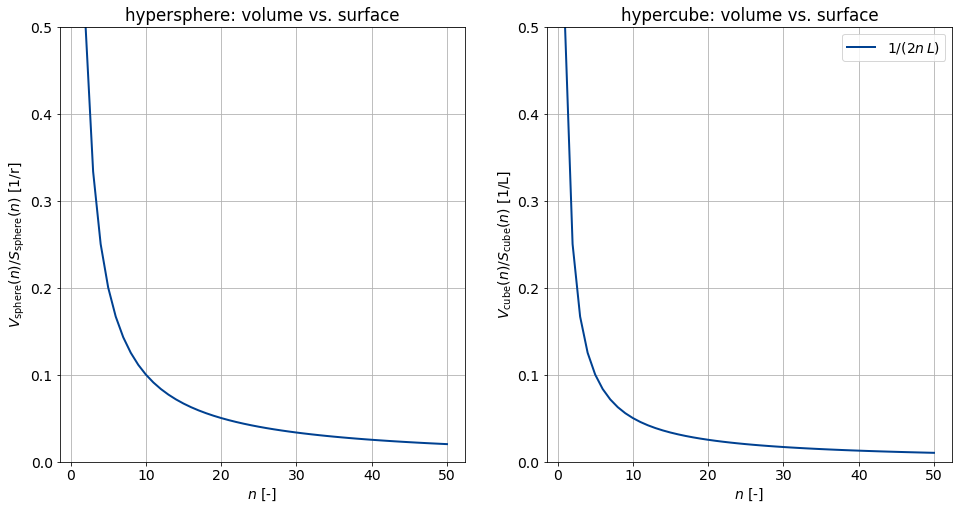

In [3]:
n = 50
V_sphere, S_sphere = hypersphere_properties( n, radius = 1 )
y_sphere = V_sphere/S_sphere

V_cube, S_cube = hypercube_properties( n, sidelength = 1 )
y_cube = V_cube/S_cube

fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(np.arange(1,n+1),y_sphere,'-',color=Sblue,linewidth=2)
ax[0].set_xlabel(r'$n$ [-]')
ax[0].set_ylabel(r'$V_{\rm sphere}(n)/S_{\rm sphere}(n)$ [1/r]')
ax[0].set_title('hypersphere: volume vs. surface')
ax[0].set_ylim([0, 0.5])
ax[0].grid()
ax[1].plot(np.arange(1,n+1),y_cube,'-',color=Sblue,linewidth=2, label=r"$1/ (2n\, L)$")
ax[1].set_xlabel(r'$n$ [-]')
ax[1].set_ylabel(r'$V_{\rm cube}(n)/S_{\rm cube}(n)$ [1/L]')
ax[1].set_title('hypercube: volume vs. surface')
ax[1].set_ylim([0, 0.5])
ax[1].grid()
ax[1].legend()

### Observations
- surface area grows faster than the volume
- interpretation: the volume localizes on the boundary $\blacktriangleright$ interior points become rare events as $n \to \infty$ (see belows example)
- the surface area grows with $n \, \mathrm{diam}(\varOmega)^{n-1}$, i.e. exponentially in $n$
$\blacktriangleright$ number of points needed for the same density grows exponentially!

#### Example
consider a $0.5>\delta>0$-layer on the inner surface of the unit cube in $\mathbb{R}^n$ (here colored in gray):
$$ V_\mathrm{layer} = 1 - (1-2\delta)^n \approx \delta n \quad \text{for}\quad \delta \to 0, n \gg 1$$

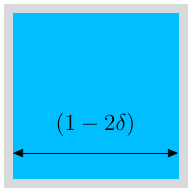

This implies that for sufficiently large $n$ a thin layer will contain virtually all points, i.e. the blue volume will tend to zero.

Example values:

In [4]:
v_inner = lambda n, delta: (1.0-2*delta)**n

for n in np.arange(500,10000+1,500):
    delta = 0.001
    print('n %5d  -  delta %12.6f   --> v_inner %12.8f %%' \
         % ( n, delta, 100*v_inner(n,delta) ) )

n   500  -  delta     0.001000   --> v_inner  36.75112549 %
n  1000  -  delta     0.001000   --> v_inner  13.50645224 %
n  1500  -  delta     0.001000   --> v_inner   4.96377321 %
n  2000  -  delta     0.001000   --> v_inner   1.82424252 %
n  2500  -  delta     0.001000   --> v_inner   0.67042966 %
n  3000  -  delta     0.001000   --> v_inner   0.24639045 %
n  3500  -  delta     0.001000   --> v_inner   0.09055126 %
n  4000  -  delta     0.001000   --> v_inner   0.03327861 %
n  4500  -  delta     0.001000   --> v_inner   0.01223026 %
n  5000  -  delta     0.001000   --> v_inner   0.00449476 %
n  5500  -  delta     0.001000   --> v_inner   0.00165187 %
n  6000  -  delta     0.001000   --> v_inner   0.00060708 %
n  6500  -  delta     0.001000   --> v_inner   0.00022311 %
n  7000  -  delta     0.001000   --> v_inner   0.00008200 %
n  7500  -  delta     0.001000   --> v_inner   0.00003013 %
n  8000  -  delta     0.001000   --> v_inner   0.00001107 %
n  8500  -  delta     0.001000   --> v_i

Even for $\delta=0.001$ the inner cube of edge length $L=0.998$ goes down to $2\cdot10^{-7} \%$ as $n=10000$.

## Singular Value Decomposition (SVD)

Let $\underline{\underline{A}} \in \mathbb{R}^{m\times n}$.

In the following different matrices are studied:
- the matrix $\underline{\underline{A}} = \begin{pmatrix} 0 & 0 & 1 \\ 1 & 2 & 0 \\ 2 & 1 & 0 \end{pmatrix}$
- a random matrix with $m=6, n=4$

In [5]:
from numpy.linalg import svd

In [6]:
A = np.array([[0,0,1],[1,2,0],[2,1,0]])
V, S, W_T = svd(A)
print('V: ', V)
print('S: ', S)
print('W: ', W_T.T)
A_reconstr = V @ np.diag(S) @ W_T

V:  [[ 1.11022302e-16 -1.00000000e+00  2.22044605e-16]
 [-7.07106781e-01 -5.55111512e-17 -7.07106781e-01]
 [-7.07106781e-01  1.11022302e-16  7.07106781e-01]]
S:  [3. 1. 1.]
W:  [[-0.70710678 -0.          0.70710678]
 [-0.70710678 -0.         -0.70710678]
 [-0.         -1.         -0.        ]]


In [7]:
m = 6
n = 4
A = np.random.uniform(0.9,1.1,size=(m,n))
M = A @ A.T
S = np.zeros((m,n))
S_i = np.zeros((n,m))
V, sig, W_T = svd(A)
sig_max = np.max(sig)
for i in range(np.min((m,n))):
    S[i,i]=sig[i]
    if( sig[i]> 1e-14*sig_max ):
        S_i[i,i]=1./sig[i]

A_inv = W_T.T @ S_i @ V.T

LSQ_A_inv = np.linalg.inv( A.T@A ) @ A.T

#print('pseudo-inverse of A via SVD: ', A_inv)
#print('pseudo-inverse of A via least square problem: ', LSQ_A_inv)
print('singular values of A: ', sig)
cond_A = np.max(sig)/np.min(sig)
cond_LSQ_A = np.linalg.cond(A.T@A)
print('condition: %12.6f (with SVD / Moore-Penrose pseudo-inverse)' % ( cond_A ) )
print('condition: %12.6f (via least squares)' % ( cond_LSQ_A) )
print('|| PseudoInv(A) - (A A^T)^-1 A.T ||_F = %16.8e' % \
     ( np.linalg.norm((A_inv - LSQ_A_inv).flatten()) ) )

V_compact, sig_compact, W_T_compact = svd(A,full_matrices=False)
print()
print('-------------------------------------------------')
print()
print('Full SVD vs. compact SVD (to be used for rectangular matrices)')
print('size(V):           ', V.shape, '   size(V_compact):   ', V_compact.shape)
print('size(sig):         ', sig.shape, '     size(sig_compact): ', sig_compact.shape)
print('size(W):           ', W_T.T.shape, '   size(W_compact):   ', W_T_compact.T.shape)
print()
print('Same for A.T:')
V, sig, W_T = svd(A.T)
V_compact, sig_compact, W_T_compact = svd(A.T,full_matrices=False)
print()
print('size(V):           ', V.shape, '   size(V_compact):   ', V_compact.shape)
print('size(sig):         ', sig.shape, '     size(sig_compact): ', sig_compact.shape)
print('size(W):           ', W_T.T.shape, '   size(W_compact):   ', W_T_compact.T.shape)

print('-------------------------------------------------')
V, sig, W_T = svd(A, full_matrices=False)
B = V @ np.diag(sig) @ V.T
print('Now: B is 6x6 with rank <= 4')
V, sig, W_T = svd(B,full_matrices=False,)
print('(thin SVD gives the same results)')
print('size(V):   ', V.shape)
print('size(sig): ', sig.shape)
print('size(W):   ', W_T.T.shape)

TOL      = 1e-14*sig.max()
idx      = (sig>TOL)
print('dimension of the kernel of B: %d' % (np.sum(sig<=TOL)))
V_compact   = V[:,idx]
W_T_compact = W_T[idx,:]
sig_compact = sig[idx]
print('size(V_compact):   ', V_compact.shape)
print('size(sig_compact): ', sig_compact.shape)
print('size(W_compact):   ', W_T_compact.T.shape)


singular values of A:  [4.88595806 0.14911863 0.13860946 0.0994766 ]
condition:    49.116656 (with SVD / Moore-Penrose pseudo-inverse)
condition:  2412.445855 (via least squares)
|| PseudoInv(A) - (A A^T)^-1 A.T ||_F =   1.06999524e-12

-------------------------------------------------

Full SVD vs. compact SVD (to be used for rectangular matrices)
size(V):            (6, 6)    size(V_compact):    (6, 4)
size(sig):          (4,)      size(sig_compact):  (4,)
size(W):            (4, 4)    size(W_compact):    (4, 4)

Same for A.T:

size(V):            (4, 4)    size(V_compact):    (4, 4)
size(sig):          (4,)      size(sig_compact):  (4,)
size(W):            (6, 6)    size(W_compact):    (6, 4)
-------------------------------------------------
Now: B is 6x6 with rank <= 4
(thin SVD gives the same results)
size(V):    (6, 6)
size(sig):  (6,)
size(W):    (6, 6)
dimension of the kernel of B: 2
size(V_compact):    (6, 4)
size(sig_compact):  (4,)
size(W_compact):    (6, 4)


### Observations
- the SVD allows for straight-forward definition of the Moore-Penrose pseudo-inverse
- the condition for computation of the pseudo-inverse is significantly improved over the straight-forward use of the least squares matrix $\underline{\underline{M}}$:
$$ \underline{\underline{A}}^\dagger = \underline{\underline{W}} \, \underline{\underline{\Sigma}}^{-1} \underline{\underline{V}}^\mathsf{T}
\qquad \text{versus} \qquad
\underline{\underline{A}}^\# = \underline{\underline{M}}^{-1} \underline{\underline{A}}^\mathsf{T} \quad\text{with}\quad
\underline{\underline{M}} = \underline{\underline{A}}^\mathsf{T} \underline{\underline{A}}$$
with $\mathrm{cond}\left( \underline{\underline{M}} \right) = \left( \mathrm{cond} \left( \underline{\underline{A}}\right) \right)^2 = \left(\displaystyle  \frac{ \mathrm{max}\  \sigma_i }{ \mathrm{min} \  \sigma_i} \right)^2$
- the improved accuracy is directly reflected in reduced numerical truncation
- the SVD version is usable also if the matrix is rank-defficient
- compact SVD omits information on the kernel of $\underline{\underline{A}}$ (preferred option)

## SVD for image compression

Now let $\underline{\underline{A}}\in\mathbb{R}^{m\times n}$ represent a grayscale image.

**Objective:** investigate the use of the truncated SVD for image compression

**Note:** The truncated SVD computation is realized via `sklearn.utils.extmath.randomized_svd`. In `MATLAB` the corresponding function is `svds`. For large data sets the direct computation of the truncated SVD (instead of truncating the thin SVD) is strongly advised.

<ipython-input-15-3c6c2363a7c7>:41: RuntimeWarning: divide by zero encountered in log10
  ax[ct+4].imshow(np.log10(np.abs(A-img)),cmap=plt.cm.hot,vmax=0,vmin=-6)


image 1: i=  1  -  rel. error:      6.38046 %
image 1: i=  2  -  rel. error:      3.36572 %
image 1: i=  6  -  rel. error:      0.53237 %
image 2: i=  1  -  rel. error:      0.00000 %
image 2: i=  2  -  rel. error:      0.00000 %
image 2: i=  3  -  rel. error:      0.00000 %
image 3: i=  4  -  rel. error:     11.78726 %
image 3: i= 12  -  rel. error:      8.78930 %
image 3: i= 32  -  rel. error:      6.27022 %
24


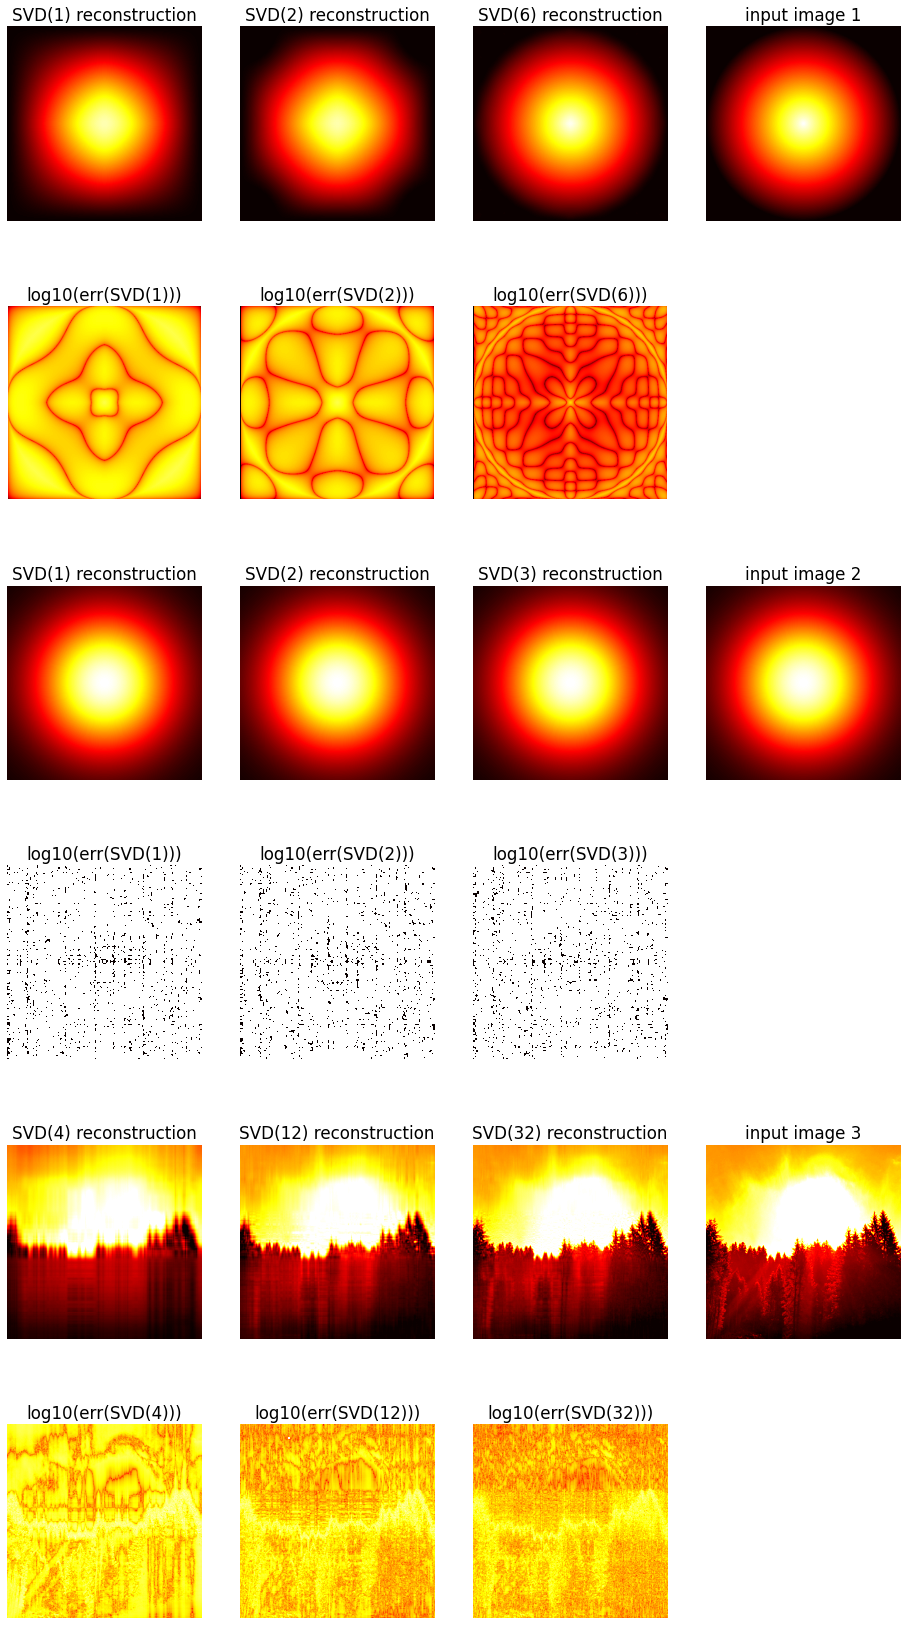

In [15]:
from sklearn.utils.extmath import randomized_svd

fig, ax = plt.subplots( 6,4,figsize=(16,30) )
ax      = ax.flatten()

img_list = []

# resolution
N       = 512
x       = np.linspace(-1,1,N)
X       = np.outer( x, np.ones(N) )
Y       = X.T
R_sq    = X**2
R_sq    = R_sq + R_sq.T

# first image: radial gradient
img_list.append( np.maximum( 0, 1-np.sqrt(R_sq)) )
# second image: Gaussian:
g = 2 # 1/sigma^2
img_list.append( np.exp(-g*R_sq) )

# third image: 512x512 real image
img_list.append( mpimg.imread('sample_img.png'))

# radial gradient:
#img     = np.sqrt(R_sq)
r_max   = 32

N = np.array([[ 1, 2, 6  ], [1,2,3], [4,12,32]])

ct = 0
img_ct=1
for img in img_list:
    V, S, W_T = randomized_svd(img, 
                                  n_components=r_max,
                                  n_iter=15,
                                  random_state=None)
    norm_img = np.linalg.norm(img.flatten())
    for n in N[img_ct-1,:]:
        A = V[:,:n] @ np.diag(S[:n]) @ W_T[:n, :]
        ax[ct+4].imshow(np.log10(np.abs(A-img)),cmap=plt.cm.hot,vmax=0,vmin=-6)
        ax[ct+4].set_title('log10(err(SVD(%d)))'%n)
        ax[ct].imshow(A,cmap=plt.cm.hot,vmax=1,vmin=0)
        ax[ct].set_title('SVD(%d) reconstruction'%n)
        print('image %d: i=%3d  -  rel. error: %12.5f %%' % \
              (img_ct, n, np.linalg.norm((A-img).flatten()) / norm_img * 100.0 ) )
        ct+=1
        
    ax[ct].imshow(img, vmin=0, vmax=1, cmap=plt.cm.hot)
    ax[ct].set_title('input image %d'%img_ct)
    ct+=1
    img_ct+=1
    ct+=4
        
for AX in ax:
    AX.axis('off')
    
print(ct)


### Observations
- the radial kernel yields a low-rank representation
- the discrete values of a Gaussian $g_{ij}$ on a regular coordinate array defined as
$$x_{ij} = x_i, \qquad y_{ij} = y_j, \qquad g_{ij} = \exp ( -\gamma ( x_{ij}^2 + y_{ij}^2 ) )$$
  is a rank-1 matrix

### Voluntary homework
Prove the previous statement, i.e. show that $\underline{\underline{g}}$ is always a rank-1 matrix. Provide an explicit construction of $\underline{\underline{g}}$ and provide the singular value $\sigma_1>0$ (suppose $\underline{x}\in\mathbb{R}^m, \underline{y}\in\mathbb{R}^n$ and $\gamma>0$ are given)

This statement is independent of
- the resolution in $x$ and $y$ direction ($m$ and $n$, respectively)
- the positive kernel parameter $\gamma>0$

---

## Proper Orthogonal Decomposition

### Definition of the reduced subspace
- use a general inner product function
$$\left( u, v \right)_M = \dots$$
- the snapshots $s_i\in\mathcal{V}, i\in\{1, \dots, n_\mathsf{s}\}$ are given
- compute the snapshot correlation matrix $\underline{\underline{C}} \in Sym_{\geq 0}(\mathbb{R}^{n_\mathsf{s}})$
$$C_{ij} = C_{ji} = \left( s_i, s_j \right)_M$$
- eigendecomposition of $\underline{\underline{C}}$
$$\underline{\underline{C}} = \underline{\underline{V}} \, \underline{\underline{\Lambda}} \, \underline{\underline{V}}^\mathsf{T}$$
  (with order eigenvalues: $\Lambda=\mathrm{diag}(\lambda_1, \dots, \lambda_{n_\mathsf{s}})$ with $\lambda_1 \geq \lambda_2 \geq \dots \geq 0$)
- truncate $\underline{\underline{C}}$ to $N \leq n_\mathsf{s}$
$$\underline{\underline{\widetilde{V}}} = \mathrm{col\, trunc} (\underline{\underline{V}}, N), \qquad
\underline{\underline{\widetilde{\Lambda}}} = \mathrm{diag}(\lambda_i: \ i=1, \dots, N)$$
- construct reduced linear subspace from the snapshots
$$b_i = \sum_{j=1}^{n_\mathsf{s}} s_j \widetilde{V}_{ji} \lambda_i^{-1/2}$$
  which translates into
$$\underline{\underline{B}} = [\underline{b}_1, \, \underline{b}_2, \dots ] = \underline{\underline{S}} \, \underline{\underline{\widetilde{V}}} \,\underline{\underline{\widetilde{\Lambda}}}^{-1/2} $$
  if the snapshots and the reduced basis functions are represented as discrete vectors

### Observations
The new basis is orthonormal:
$$ (b_i, b_j)_M = \lambda_i^{-1/2} \lambda_j^{-1/2} \underline{v}_i^\mathsf{T} \underline{\underline{C}} \underline{v}_j = \lambda_i^{-1/2} \lambda_j^{-1/2} \delta_{ij} \lambda_i = \delta_{ij} $$
Or in the discrete setting:
$$ \underline{\underline{B}}^\mathsf{T} \underline{\underline{M}} \, \underline{\underline{B}} = 
\underline{\underline{\widetilde{\Lambda}}}^{-1/2} \underline{\underline{\widetilde{V}}}^\mathsf{T}
\underline{\underline{S}}^\mathsf{T} \underline{\underline{M}} \,
\underline{\underline{S}} \, \underline{\underline{\widetilde{V}}} \,\underline{\underline{\widetilde{\Lambda}}}^{-1/2} = 
\underline{\underline{\widetilde{\Lambda}}}^{-1/2} \underline{\underline{\widetilde{V}}}^\mathsf{T}
\underline{\underline{C}} \, \underline{\underline{\widetilde{V}}} \,\underline{\underline{\widetilde{\Lambda}}}^{-1/2} = 
\underline{\underline{\widetilde{\Lambda}}}^{-1/2} \underline{\underline{\widetilde{V}}}^\mathsf{T}
\underline{\underline{V}} \underline{\underline{\Lambda}} \,
\underline{\underline{V}}^\mathsf{T} \, \underline{\underline{\widetilde{V}}} \,\underline{\underline{\widetilde{\Lambda}}}^{-1/2} = 
\underline{\underline{\widetilde{\Lambda}}}^{-1/2} \underline{\underline{\widetilde{\Lambda}}}\,\underline{\underline{\widetilde{\Lambda}}}^{-1/2} = \underline{\underline{I}}$$

### Orthogonal projection
**given** a new sample $v\in\mathcal{V}$

**seek** the projection onto the $N$ dimensional subspace

$$ \mathcal{P}_N v = \sum_{i=1}^N \xi_i b_i, \qquad \xi_i = ( b_i, v )_M $$

The coefficients $\xi_i$ stem from the minimum problem
$$\underline{\xi} = \underset{\underline{\eta}\in\mathbb{R}^N}{\mathrm{arg\,min}} \Big\lVert v - \sum_{i=1}^N \eta_i b_i \Big\rVert_M^2 $$

In [9]:
def inner_product( u, v, M=None ):
    """ compute some inner product on inputs u, v
    
    Parameters:
    -----------
    u:   first vector (numpy.array(n))
    v:   second vector (numpy.array(n))
    M:   symmetric positive metrix (None or sparse/dense matrix)
    
    Returns:
    --------
    inner product of u and v (float)
    
    """
    # simplistic example: Euclidean inner product
    if( M==None ):
        return np.inner(u, v)
    else:
        return np.inner( u, M@v )

def orthogonal_projection( u, B, M=None):
    """ project u onto B
    
    Parameters:
    -----------
    u:   vector or matrix (numpy.array(n) or numpy.array(n,m))
    B:   reduced basis
    M:   symmetric positive metrix (None or sparse/dense matrix)
    
    Returns:
    --------
    projection u_N and reduced coefficients
    
    """
    if( M == None ):
        xi = u@B
    else:
        xi = (u@M)@B
    u_N = B@xi
    return u_N, xi

|| B^T M B - I ||_F =     4.475088e-15
|| B^T M B - I ||_F =     5.683380e-15


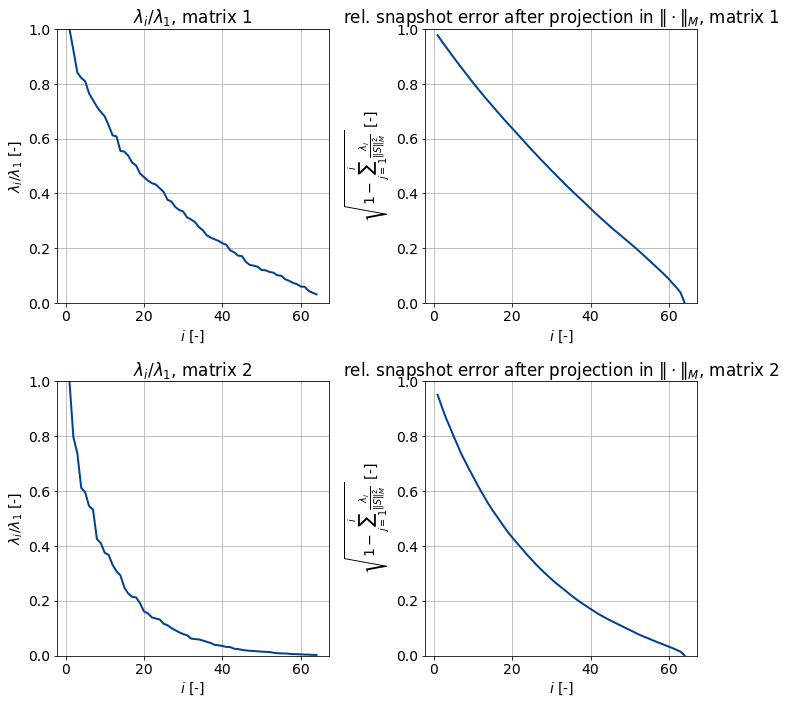

In [10]:
n   = 128  # number of unknowns
n_s = 64    # number of snapshots
N   = 16
# random data:
S   = np.random.normal(0,1,size=(n,n_s))
M_list = []
M_list.append(None)
M_list.append(np.diag(np.exp(np.linspace(-5,2,n))))
fig, ax = plt.subplots(2,2,figsize=(10,10))
ct=0
for M in M_list:
    if( M is None):
        C = S.T @ S
    else:
        C = S.T @ ( M @ S )
    
    norm_S = np.sqrt( C.trace() )

    sig, V = np.linalg.eigh( C )
    # order eigenvalues descendingly
    idx = np.flip(np.argsort(sig))
    sig = sig[idx]
    V   = V[:,idx]
    V_trunc = V[:,:N]
    sig_trunc = sig[:N]
    B   = S @ V_trunc @ np.diag(1/np.sqrt(sig_trunc))
    if( M is None ):
        K = B.T @ B
    else:
        K = B.T @ ( M @ B )
    print('|| B^T M B - I ||_F = %16.6e' % ( np.linalg.norm( ( np.eye(N) - K ).flatten())) )
    
    ax[ct][0].plot(np.arange(1,n_s+1), (sig/sig[0]), color=Sblue, linewidth=2)
    ax[ct][0].grid()
    ax[ct][0].set_ylim(0, 1)
    ax[ct][0].set_title(r'$\lambda_i/\lambda_1$, matrix %d' % (ct+1) )
    ax[ct][0].set_xlabel(r'$i$ [-]')
    ax[ct][0].set_ylabel(r'$\lambda_i/\lambda_1$ [-]')
    
    ax[ct][1].plot(np.arange(1,n_s+1), \
                np.sqrt(np.maximum(0, 1 - np.cumsum(sig)/norm_S**2 )), \
                color=Sblue, linewidth=2)
    ax[ct][1].grid()
    ax[ct][1].set_ylim(0, 1)
    ax[ct][1].set_title(r'rel. snapshot error after projection in $\Vert \cdot \Vert_M$, matrix %d' % (ct+1) )
    ax[ct][1].set_xlabel(r'$i$ [-]')
    ax[ct][1].set_ylabel(r'$ \sqrt{1- \sum_{j=1}^i \frac{\lambda_i }{ \Vert S \Vert_M^2}}$ [-]')
    ct+=1
fig.tight_layout()
    

## POD of real world simulation data

### Problem setting

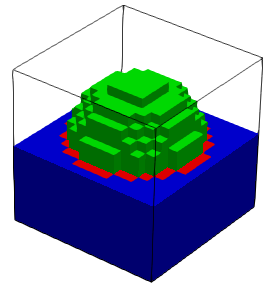

Bi-material (matrix-inclusion composite)
- green $\blacktriangleright$ inclusion (interior elements) (phase 1)
- red $\blacktriangleright$ interface elements (phase 2)
- blue $\blacktriangleright$ matrix material (phase 0)

256 different sets of material parameters are considered with:
$$E_0 = 1\,\text{GPa}, \qquad E_1 = 10\,\text{GPa}, \qquad  \nu_0, \nu_1 \in \{-0.99, -0.9, -0.8, \dots, 0.4, 0.49\}$$

The unit cell is equiped with periodic displacement fluctuation boundary conditions. The strain field $\boldsymbol{\varepsilon}(\boldsymbol{x})$ is stored on a per element basis ($32^3=32768$ elements with 6 strain components each) are stored.


In [11]:
file    = h5py.File("example_snapshot_data.h5", "r")
print('Start reading the data...')
dset_name= lambda n: ('sphere/32x32x32/strain/bbar_%d'%n)
n_s     = 256
n       = 6*32768
C       = np.zeros((n_s, n_s))
data    = np.zeros((n,n_s))
for n in range(n_s):
    d = np.array(file[dset_name(n)])
    # substract the mean strain
    d -= np.mean(d, axis=1)[:,None]
    data[:,n] = d.flatten()
C = data.T @ data
norm_S_sq= C.trace()
Lambda,V= np.linalg.eigh(C)
idx     = np.flip( np.argsort(Lambda) )
Lambda  = Lambda[idx]
V       = V[:,idx]
print('Done.')

Start reading the data...
Done.


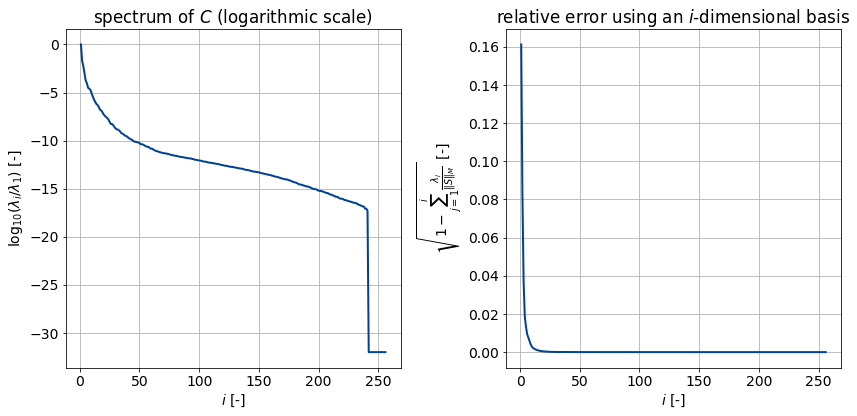

In [16]:
err = np.sqrt( np.positive( 1 - np.cumsum(Lambda)/norm_S_sq ) )

fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].plot(np.arange(1,n_s+1), np.log10(np.maximum(Lambda/Lambda[0],1e-32)), color=Sblue, linewidth=2)
ax[1].plot(np.arange(1,n_s+1), err,  color=Sblue, linewidth=2)

ax[0].set_ylabel(r'$\log_{10}( \lambda_i / \lambda_1 )$ [-]')
ax[0].set_title('spectrum of $C$ (logarithmic scale)')

ax[1].set_ylabel(r'$\sqrt{1 -  \sum_{j=1}^i \frac{\lambda_i}{\Vert S \Vert_M}}$ [-]')
ax[1].set_title('relative error using an $i$-dimensional basis')

for AX in ax:
    AX.grid()
    AX.set_xlabel('$i$ [-]')
    
plt.tight_layout()

### Observations
- relatively low number of basis functions will give a solid accuracy 
- spectrum hints at great reducibility

### To be done next
- set a tolerance and figure the number of modes needed in order to get the requested accuracy
- compute the reduced basis
- plot a cumulative frequency of the error observed over the 256 snapshots

In [13]:
N=0
TOL=1e-3
while( N<n_s and err[N]>TOL ):
    N+=1
print('Using N=%d modes the error is %12.4e (TOL: %12.4e)' % ( N, err[N], TOL ) )

B       = data@ ( V[:,:N] @ np.diag( 1/np.sqrt(Lambda[:N])) )
Xi      = B.T @ data
P_data  = B @ Xi
ERR     = data - P_data
err_i   = 100* np.linalg.norm(ERR,axis=0) / np.maximum( 1e-16, np.linalg.norm(data,axis=0) )

idx = np.argsort(err_i)
print('10 largest errors with more metadata', np.flip(idx[-10:]))

# parse the material data for these samples:
for I in idx[-10:]:
    dset = file[dset_name(I)].attrs
    nu = dset.get('Poisson ratio')
    print('err_%3d = %8.4f %% for nu = ' %( I, err_i[I] ), nu )

print('10 smallest errors with more metadata', np.flip(idx[:10]))

# parse the material data for these samples:
for I in idx[:10]:
    dset = file[dset_name(I)].attrs
    nu = dset.get('Poisson ratio')
    print('err_%3d = %8.4f %% for nu = ' %( I, err_i[I] ), nu )


Using N=14 modes the error is   9.2767e-04 (TOL:   1.0000e-03)
10 largest errors with more metadata [31 30 47 29 63 46 28 79 27 45]
err_ 45 =   0.3273 % for nu =  [-0.8  0.3]
err_ 27 =   0.3473 % for nu =  [-0.9  0.1]
err_ 79 =   0.4010 % for nu =  [-0.6   0.49]
err_ 28 =   0.4278 % for nu =  [-0.9  0.2]
err_ 46 =   0.4543 % for nu =  [-0.8  0.4]
err_ 63 =   0.5201 % for nu =  [-0.7   0.49]
err_ 29 =   0.5596 % for nu =  [-0.9  0.3]
err_ 47 =   0.7143 % for nu =  [-0.8   0.49]
err_ 30 =   0.7625 % for nu =  [-0.9  0.4]
err_ 31 =   1.1003 % for nu =  [-0.9   0.49]
10 smallest errors with more metadata [166 150 115 148 133 116 149 132  26   1]
err_  1 =   0.0000 % for nu =  [-0.99 -0.9 ]
err_ 26 =   0.0000 % for nu =  [-0.9  0. ]
err_132 =   0.0314 % for nu =  [-0.2 -0.6]
err_149 =   0.0330 % for nu =  [-0.1 -0.5]
err_116 =   0.0338 % for nu =  [-0.3 -0.6]
err_133 =   0.0343 % for nu =  [-0.2 -0.5]
err_148 =   0.0360 % for nu =  [-0.1 -0.6]
err_115 =   0.0360 % for nu =  [-0.3 -0.7]
err_

### Remark
The scenario $\nu_0 = -0.9, \ \nu_1 = 0.49$ leads to
$$K_i = \frac{E_i}{3(1-2\nu_i)}, \qquad G_i = \frac{E_i}{2(1+\nu_i)} \qquad (K_0, G_0) = (0.1186, 50.0) \, \text{GPa}\qquad (K_1, G_1) = (166.7, 3.356) \, \text{GPa}$$

For this particular scenario the bulk modulus of the matrix phase is more than a factor 1000 lower than that of the inclusion while the shear modulus of the matrix is 14.9 times as high as that of the inclusion. This combination yields the highest phase contrasts among all input samples, which is reflected in the solution field. Since such harsh material contrasts were seldom in the snapshots, features of this solution field were not considered in the reduced subspace with priority by the snapshot POD. That explains the increased projection error. The same holds for the other samples that fall into the top 10 of the highest projection errors: all have particularly high contrast in the shear modulus.

median of error:   0.0781 %
maximum error:     1.1003 %


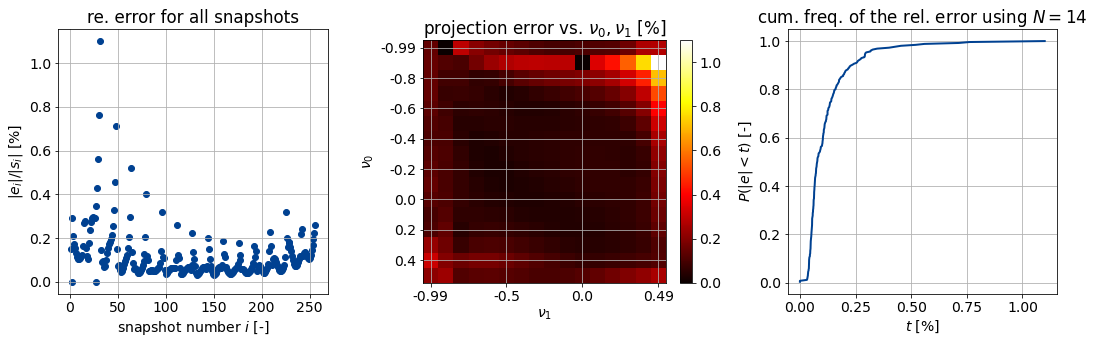

In [14]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].scatter(np.arange(1,n_s+1), err_i ,  color=Sblue)
ax[0].set_ylabel(r'$\vert e_i \vert / \vert s_i \vert $ [%]')
ax[0].set_title('re. error for all snapshots')
ax[0].set_xlabel('snapshot number $i$ [-]')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.2)
plt.colorbar( ax[1].imshow( err_i.reshape(16,16), cmap=plt.cm.hot), cax=cax)
ax[1].set_ylabel(r'$\nu_0$')
ax[1].set_xlabel(r'$\nu_1$')
#ax1.set_xticklabels(['', 0,10,20,30,40])
nu = [-0.99, -0.9, -0.7, -0.6, -0.5, -0.4, -0.3, \
      -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.49]
tic=ax[1].get_xticks()
tic = tic[tic >= 0]
tic = tic[tic <= 15]
tic_label = np.round(tic - 10) / 10
tic_label[tic_label == -1.0 ] = -0.99
tic_label[tic_label == 0.5 ] = 0.49
ax[1].set_xticks( tic )
ax[1].set_xticklabels( tic_label )

tic=ax[1].get_yticks()
tic = tic[tic >= 0]
tic = tic[tic <= 15]
tic_label = np.round(tic - 10) / 10
tic_label[tic_label == -1.0 ] = -0.99
tic_label[tic_label == 0.5 ] = 0.49
ax[1].set_yticks( tic )
ax[1].set_yticklabels( tic_label )
ax[1].set_title(r'projection error vs. $\nu_0, \nu_1$ [%]')


ax[2].plot( np.sort(err_i), np.arange(1,n_s+1)/n_s,  color=Sblue, linewidth=2 )
ax[2].set_ylabel(r'$P(\vert e \vert < t)$ [-]')
ax[2].set_xlabel(r'$t$ [%]')
ax[2].set_title('cum. freq. of the rel. error using $N=%d$'%(N))

med_err = np.median(err_i)
print('median of error: %8.4f %%' % (med_err))
print('maximum error:   %8.4f %%' % (err_i.max()))

for AX in ax:
    AX.grid()
    
plt.tight_layout()

### Observations
- using 14 modes the entire 256 snapshots can be approximated such that the peak error is just above 1%
- the largest error is related to the highest contrast in the Poisson ratio
- the use of HDF5 and the access of attributes is illustrated
- the visualization using the empirical distribution function of the error helps in judging on the quality of the approximation

## POD via SVD

**Assumptions**
- discrete $n$-dimensional data mit inner product matrix $\underline{\underline{M}}\in Sym_+(\mathbb{R}^n)$
- snapshot data stored in matrix form: $\underline{\underline{S}}\in\mathbb{R}^{n \times n_\mathsf{s}}$

**Algorithm**
- compute the Cholesky decomposition of $\underline{\underline{M}} = \underline{\underline{L}} \, \underline{\underline{L}}^\mathsf{T}$
- examine the correlation matrix:
$$ \underline{\underline{C}} = \underline{\underline{S}}^\mathsf{T} \underline{\underline{M}} \underline{\underline{S}} = \underline{\underline{S}}^\mathsf{T} \underline{\underline{L}} \, \underline{\underline{L}}^\mathsf{T} \underline{\underline{S}} = \underline{\underline{\widetilde{S}}}^\mathsf{T} \underline{\underline{\widetilde{S}}} \qquad \text{with}\qquad \underline{\underline{\widetilde{S}}} = \underline{\underline{L}}^\mathsf{T} \underline{\underline{S}} $$
- the matrix $\underline{\underline{\widetilde{S}}}$ can be considered as a coordinate transformed version of $\underline{\underline{S}}$
- compute the SVD of $\underline{\underline{\widetilde{S}}}$:
$$ \underline{\underline{\widetilde{S}}} = \underline{\underline{V}} \, \underline{\underline{\Sigma}} \, \underline{\underline{W}}^\mathsf{T} \qquad \Rightarrow \qquad \underline{\underline{C}} = \underline{\underline{W}} \, \underline{\underline{\Sigma}} \, \underline{\underline{V}}^\mathsf{T} \underline{\underline{V}} \, \underline{\underline{\Sigma}} \, \underline{\underline{W}}^\mathsf{T} = \underline{\underline{W}} \, \underline{\underline{\Sigma}}^2 \underline{\underline{W}}^\mathsf{T} $$
- the basis of the reduced subspace is obtained as
$$ \underline{\underline{B}} = \underline{\underline{S}} \underline{\underline{\widetilde{W}}} \, \underline{\underline{\widetilde{\Lambda}}}^{-1/2}
= \underline{\underline{L}}^{-\mathsf{T}} \underline{\underline{\widetilde{S}}} \, \underline{\underline{\widetilde{W}}} \, \underline{\underline{\widetilde{\Sigma}}}^{-1} 
=  \underline{\underline{L}}^{-\mathsf{T}} \underline{\underline{V}} \, \underline{\underline{\Sigma}} \, \underline{\underline{W}}^\mathsf{T} \underline{\underline{\widetilde{W}}} \, \underline{\underline{\widetilde{\Sigma}}}^{-1} 
= \underline{\underline{L}}^{-\mathsf{T}} \underline{\underline{\widetilde{V}}} $$


In summary, the truncated SVD of the coordinate transformed matrix $\underline{\underline{\widetilde{S}}}$ followed by a back-transform (via $\underline{\underline{L}}^{-\mathsf{T}}$) yields the same orthonormal basis as the correlation matrix aproach.


### Advantages of the SVD
- The computation by-passes the actual computation of $\underline{\underline{C}}$.
- Numerical truncation is reduced since the singular values $\sigma_i$ are related to the eigenvalues $\lambda_i$ of $\underline{\underline{C}}$ via $\sigma_i = \sqrt{\lambda_i}$ $\blacktriangleright$.
- The SVD approach is not prone to suffer from complex valued outputs.

### Disadvantages of the SVD
- The matrix $\underline{\underline{M}}$ must be available $\blacktriangleright$ impossible for continuous function spaces
- The factorization of $\underline{\underline{M}}$ can be costly or impossible (due to memory limitations), depending on the dimension of the data and the sparsity pattern of $\underline{\underline{M}}$.
- Parallelization is straight-forward for the correlation matrix approach. However, it is limited to a parallel version of the SVD.